# Part One - Finding the Key from a Synthetic Power Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

This part aims to generate for a particular key (as shown in the attached AES_GenPowerProfile.c file)

`{0x2b, 0x7e, 0x15, 0x16, 0x28, 0xae, 0xd2, 0xa6, 0xab, 0xf7, 0x15, 0x88, 0x09, 0xcf, 0x4f, 0x3c}`

 A collection of power traces that contain for each message with 32 bytes

* The Ciphertext can be found in the CIPHERFILE.dat file on the site
* In the state at the entrance to round 9, you can calculate using inverse pomegranates in the DoM_actual_wrapper.py file (requires adjustments)
* It is required to create two tables, one for calculating the power based on HW and the other while relying on HD
    * HW - how many "1 "s are in the state to end each Round
    * HD - how many bits were changed between the state at the end of each stage, compared to the value of the state in the previous stage (the initial state (not in the table) is the input)
    
At the end of this stage you have "in your hands" two matrices with the help of which we can predict the key with which we have encrypted all the messages (place the same key)

`{ 0xd0, 0x14, 0xf9, 0xa8, 0xc9, 0xee, 0x25, 0x89, 0xe1, 0x3f, 0x0c, 0xc8, 0xb6, 0x63, 0x0c, 0xa6}`

Here is an extension of the key for round 9, we would like to get the first key of this step

In [2]:
AVICHART_PATH = "./Resources/AVICHART.dat"
SAMPLEFILE_PATH = "./Resources/SAMPLEFILE.dat"
SAMPLEFILE_HD_PATH = "./Resources/SAMPLEFILE_HD.dat"
SAMPLEFREQFILE_PATH = "./Resources/SAMPLEFREQFILE.dat"

In [3]:
HD_table = []
HW_table = []
C_P_table = []
with open(AVICHART_PATH,"r") as fp: 
    for line in fp: 
        temp = line.split()
        C_P_table += [[temp[0],temp[1]]]
        HW_table += [temp[2:14]]
        HD_table += [temp[14:]]
display(len(C_P_table))

5000

In [4]:
display(pd.DataFrame(np.column_stack((C_P_table, HW_table)), columns=["PT","CT"] + [f"R{i}" for i in range(1,13)]))

,PT,CT,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12
0,67c6697351ff4aec29cdbaabf2fbe346,9c8a50cdfcfd9160f5d421bf8fd57295,5,3,4,4,7,5,3,4,4,5,5,4
1,66320db73158a35a255d051758e95ed4,4b63abca487f7e1c95c234d9664f7681,4,4,5,4,2,2,4,5,3,4,4,4
2,70e93ea141e1fc673e017e97eadc6b96,970eb501c8268b0c3ae26fda8d91277a,3,5,4,2,3,5,3,3,4,4,3,5
3,021afe43fbfaaa3afb29d1e6053c7c94,f46f2d4ecc3423f1641d50c0470dd72d,1,3,5,4,5,5,3,5,3,5,4,5
4,05eff700e9a13ae5ca0bcbd0484764bd,0a8e754595ea0142cab17e20c060e8bb,2,4,3,3,3,3,4,3,4,3,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,b2ab553190c00931918eb487fe270135,e83f249ff9ff4dda57a98ac42299cf1a,4,4,6,4,6,3,3,3,3,6,5,4
4996,1f63f8af2302e0b590943c8fbc3ec449,42ea5ebdf7ad3fcc41e0fd542a5fb760,5,3,0,5,4,5,4,2,4,4,4,2
4997,9fcbaec3cd8e785d23b4ecdff2b02899,cf3812ddff18d8ab97ea1f8c06d08f3b,6,4,6,3,5,2,3,4,6,6,5,6
4998,6d866c3a15e498389884178b353f24bb,ca0f78ffb158d13313c5a8d08f06a4fa,5,3,3,4,4,5,2,4,6,2,3,4


In the table above, in each round and for each trace, we use the Hamming weight model to estimate the power that is calculated for that round.

In [5]:
display(pd.DataFrame(np.column_stack((C_P_table, HD_table)), columns=["PT","CT"] + [f"R{i}" for i in range(1,12)]))

,PT,CT,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11
0,67c6697351ff4aec29cdbaabf2fbe346,9c8a50cdfcfd9160f5d421bf8fd57295,4,5,6,3,2,6,3,6,3,2,3
1,66320db73158a35a255d051758e95ed4,4b63abca487f7e1c95c234d9664f7681,4,5,5,4,2,2,3,4,5,4,4
2,70e93ea141e1fc673e017e97eadc6b96,970eb501c8268b0c3ae26fda8d91277a,4,5,4,3,6,4,4,5,6,3,2
3,021afe43fbfaaa3afb29d1e6053c7c94,f46f2d4ecc3423f1641d50c0470dd72d,4,4,7,7,4,4,4,4,6,3,3
4,05eff700e9a13ae5ca0bcbd0484764bd,0a8e754595ea0142cab17e20c060e8bb,4,5,4,4,6,3,3,5,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,b2ab553190c00931918eb487fe270135,e83f249ff9ff4dda57a98ac42299cf1a,4,6,2,4,3,4,2,4,5,3,5
4996,1f63f8af2302e0b590943c8fbc3ec449,42ea5ebdf7ad3fcc41e0fd542a5fb760,4,3,5,3,5,3,4,4,6,4,4
4997,9fcbaec3cd8e785d23b4ecdff2b02899,cf3812ddff18d8ab97ea1f8c06d08f3b,4,2,5,4,5,1,3,2,2,5,1
4998,6d866c3a15e498389884178b353f24bb,ca0f78ffb158d13313c5a8d08f06a4fa,4,4,3,4,3,3,4,6,6,5,3


In the table above, in each round and for each trace, we use the Hamming distance model to estimate the power that is calculated for that round.

After creating the tables, we will begin the "prediction" process of the key, using the DOM method learned in class. The method works as follows (suppose here we want to guess the value of the first byte of the key, using the right bit (LSB) of the byte)

In [6]:
samples = []        
with open(SAMPLEFILE_PATH,"r") as fp: 
    for line in fp: 
        samples += [np.array([int(i) for i in line.split()])]
display(len(samples))

256

In [7]:
samples_hd = []
with open(SAMPLEFILE_HD_PATH,"r") as fp:
    for line in fp:
        samples_hd += [np.array([int(i) for i in line.split()])]
display(len(samples_hd))

256

In [8]:
sample_freqs = []
with open(SAMPLEFREQFILE_PATH,"r") as fp: 
    for line in fp: 
        sample_freqs += [int(line.split()[0])]
display(len(sample_freqs))

256

* The Ciphertext can be found for all traces in the table (third column, CT). Hundreds or thousands of footprints should be taken
* For each byte in Ciphertext we will go over all the possible values ​​of the selected byte of the developer
    * Using the inverse functions (also given in the file) calculate what was the value of the state which was used as input to the phase
    * Based on the value of select bit, suppose we have chosen the LSB of the byte, we will sum their power value, at their absolute value, or to bin0 or bin1. For all 12 sampling points
    * At the end of the transition on all the encrypted messages, we will get two vectors which should normalize them according to the number of messages used in each bin
    * The normal vectors we subtract from each other and the absolute value of the differences, at the various points, is used to select the key, using one of the following three cryorions
        * The key used to create the largest difference for the selected byte
        * The key used to create the largest difference for one of the sampling points (vector point)
        * The key used to create the large average difference
        

In [9]:
InvSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

# TARGET_BYTE = 4
BIT_MASK = 2**5
HW_max_list = []
HD_max_list = []
keys_guesses = [i for i in range(256)]

## Find key by Hamming Weight


In [10]:
key = -1
_max = 0
for key_guess in keys_guesses:
    p_0 = np.zeros(12) #The differences are averages of LSB = 0
    n_0 = 0
    p_1 = np.zeros(12) #The differences are averages of LSB = 1
    n_1 = 0
    for idx in range(256):
        select_bit = 0 if (InvSbox[key_guess ^ idx] & BIT_MASK == 0) else 1
        if select_bit == 0:
            p_0 += samples[idx]
            n_0 += sample_freqs[idx]
        else:
            p_1 += samples[idx]
            n_1 += sample_freqs[idx]

    if (n_0 != 0 and n_1 != 0):
        dom = np.abs(p_0/n_0 - p_1/n_1)
        dom_max = np.max(dom)
        HW_max_list.append(dom_max)

        if (dom_max > _max):
            _max = dom_max
            key = hex(key_guess)

    else:
        print(str(idx) + " Failed")

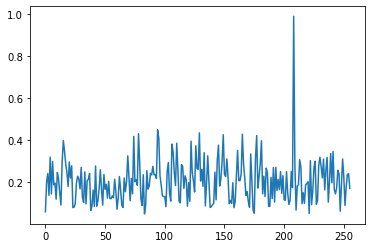

Result key is 0xd0 or 208


In [11]:
plt.plot(keys_guesses,HW_max_list)
plt.show()
print(f"Result key is {key} or {int(key,16)}")

## Find key by Hamming Distance

In [12]:
key = -1
_max = 0
for key_guess in keys_guesses:
    p_0 = np.zeros(11)
    n_0 = 0
    p_1 = np.zeros(11)
    n_1 = 0
    for idx in range(256):
        select_bit = 0 if ((InvSbox[key_guess ^ idx] & BIT_MASK) ^ (idx & BIT_MASK) == 0) else 1
        if select_bit == 0:
            p_0 += samples_hd[idx]
            n_0 += sample_freqs[idx]
        else:
            p_1 += samples_hd[idx]
            n_1 += sample_freqs[idx]

    if (n_0 != 0 and n_1 != 0):
        dom = np.abs(p_0/n_0 - p_1/n_1)
        dom_max = np.max(dom)
        HD_max_list.append(dom_max)
        
        if (dom_max > _max):
            _max = dom_max
            key = hex(key_guess)

    else:
        print(str(idx) + " Failed")

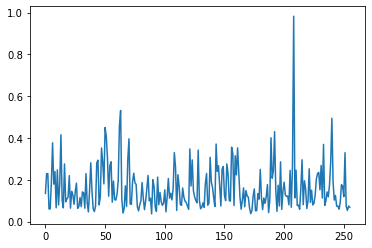

Result key is 0xd0 or 208


In [13]:
plt.plot(keys_guesses,HD_max_list)
plt.show()
print(f"Result key is {key} or {int(key,16)}")

## Conclusions

From our results, a peak can be seen in the two graphs, one for each model. The above results present the expected value. To be more precise, we were able to get the key for round number 9 (as shown at the beginning of the question). 

`{ 0xd0, 0x14, 0xf9, 0xa8, 0xc9, 0xee, 0x25, 0x89, 0xe1, 0x3f, 0x0c, 0xc8, 0xb6, 0x63, 0x0c, 0xa6}`

That is, with the help of power calculations of the AES algorithm, and with the help of the DoM methodology, we were able to predict the first byte of the key for the 9th round (**0xd0**).

* Please note that we did not consider our code in the mix columns operation and if so we managed with all the steps to recover the key. In our opinion, since this operation is not performed in the last step therefore there is enough "correlation" between the observations and the model.


#### For example the following code, will calculate the whole key for round 9
`Get_all_key.sh`: 


```
gcc ./AES_GenPowerProfile.c -o AES_GenPowerProfile -lncurses
for i in $(seq 0 15); do 
    # OUT=(`./AES_GenPowerProfile $i`)
	OUT=`./AES_GenPowerProfile $i`
	if [ $i == 0 ] 
	then 
		echo "True Round Key:    $OUT"
		printf "Extracted Key HW:  "
	fi 
	# echo "Exp#$i - extracting byte #$i of the key"; 
	# echo "${OUT[${i}]}"
	EX=`python ./part1.py HammingWeight | cut -c3-`
	printf "%02s " $EX
done
printf "\n"
for i in $(seq 0 15); do 
    ./AES_GenPowerProfile $i > /dev/null
    if [ $i == 0 ] 
	then 
		printf "Extracted Key HD:  "
    fi
    EX=`python ./part1.py HammingDistance | cut -c3-`
	printf "%02s " $EX
done
printf "\n"
```
Note that `part1.py` is a script which is customized according to the notebook 

After running the script the following results were obtained:

    True Round Key:    `d0 14 f9 a8 c9 ee 25 89 e1 3f 0c c8 b6 63 0c a6`

    Extracted Key HW:  `d0 14 f9 a8 c9 ee 25 89 e1 3f 0c c8 b6 63 0c a6`

    Extracted Key HD:  `d0 14 f9 a8 c9 ee 25 89 e1 3f 0c c8 b6 63 0c a6`


##### In the same way, and with the help of the AES algorithm we can continue the investigation and even recover the whole key

####  Extra 


* As part of the study we tried to test whether Shift Rows activity affects key recovery. You can see the results here:

    True Round Key:    `d0 14 f9 a8 c9 ee 25 89 e1 3f 0c c8 b6 63 0c a6`

    Extracted Key HW:  `d0 b1 91 6a c9 7a 5a  a e1 ee 90 4e 81 5e 7e 6e`

    Extracted Key HD:  `d0 5c fa 16 c9 1d f1 6b e1 22 7b cf b6 5e 1f ac`

    It can be seen that the bytes that are replaced in the Shift Rows were indeed affected and therefore we were unable to restore them. In contrast, the bytes in the first row can be seen as we were able to restore (for the most part).
    Therefore, we can conclude that canceling the Shift Rows operation does indeed affect our results
    
 ![Shift Rows](./Resources/shift.jpeg)